In [2]:
import subprocess
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import argparse
import hashlib
from datetime import datetime
from configparser import ConfigParser
import sys
import warnings
import re
warnings.filterwarnings('ignore')
from numpy import random

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# **Functions**

In [4]:
def convert_to_snake_case(col_name):
    # Remove '__c' from the column names
    col_name = col_name.replace('__c', '')
    
    # Replace periods with underscores
    col_name = col_name.replace('.', '_')
    
    # Convert camel case to snake case
    # Handle the case where a lowercase letter or digit is followed by an uppercase letter
    col_name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', col_name)
    
    # Convert the entire string to lowercase
    col_name = col_name.lower()
    
    # Replace multiple underscores with a single underscore
    col_name = re.sub(r'_+', '_', col_name)
    
    return col_name

In [5]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3

In [6]:
# Define the function to check the condition in cells
def contains_board_and_member(cell):
    if isinstance(cell, str):
        return 'board' in cell.lower() and 'member' in cell.lower() and \
               ('past' not in cell.lower() and 'former' not in cell.lower())
    return False

def contains_board_and_member_past(cell):
    if isinstance(cell, str):
        return 'board' in cell.lower() and 'member' in cell.lower() and \
               ('past' in cell.lower() or 'former' in cell.lower())
    return False

def contains_solicitor_and_president(cell):
    if isinstance(cell, str):
        return 'solicitor' in cell.lower() and 'president' in cell.lower() 
    return False

In [7]:
def pick_col(row, col1, col2):
    x, y = row[col1], row[col2]
    if pd.isna(x) and pd.isna(y):
        return np.nan
    elif pd.isna(x):
        return y
    elif pd.isna(y):
        return x
    elif x == y:
        return x
    else:
        print(x, y)
        return np.nan

In [8]:
def df_merge_source(merged_df, left_source, right_source):
    # Rename the '_merge' column to 'source'
    new_col = "df_source"
    while new_col in merged_df.columns:
        i = 1
        new_col = "df_source_%d" %i
        i += 1
        
    merged_df.rename(columns={'_merge': new_col}, inplace=True)
    
    # Map the source column to more descriptive labels
    source_mapping = {
        'left_only': '%s' %left_source,
        'right_only': '%s' %right_source,
        'both': '%s/%s'%(left_source, right_source)
    }
    merged_df[new_col] = merged_df[new_col].replace(source_mapping)
    return merged_df

In [9]:
def remove_dollar_sign_and_comma(cell):
    if isinstance(cell, str):
        cell = cell.replace("$", "").replace(",", "")
    return cell

In [10]:
def save_file(df, file_prefix = "constituents_cleaned", version="v1"):
    if "Unique Donor ID" in df.columns:
        df = df.dropna(subset="Unique Donor ID")
    file_name = "%s_%s.csv" %(file_prefix, version)
    df.to_csv("%s\\%s\\%s\\Cleaning\\%s" %(file_path, clients, subdir, file_name), index=False)

# **Gifts Data**

In [217]:
file_path = "C:\\Users\\Rmittal\\CCS\\Internal - Analytics - Shared Drive\\1. Shared Drive\\Clients"
subdir = "Raw Client Data\\Section 2" 
clients = "National Multiple Sclerosis Society"
file_name = "Section 2  CCS May 2024-2024-05-22-20-12-55.csv"
file = "%s\\%s\\%s\\%s" %(file_path, clients, subdir, file_name)
dfg_1 = pd.read_csv(file, encoding="ISO-8859-1")

dfg_1 = dfg_1[dfg_1["Stage"]=="Closed Won"]
dfg_1["source"] = "Section 2  CCS May 2024-2024-05-22-20-12-55.csv"
dfg_1["Close Date"] = pd.to_datetime(dfg_1["Close Date"], format="%m/%d/%Y")#, errors = "coerce")

file_name = "Section 2  CCS May 2024 Pt. 2 GAU Ref-2024-05-30-03-00-07.csv"
file = "%s\\%s\\%s\\%s" %(file_path, clients, subdir, file_name)
dfg_2 = pd.read_csv(file, encoding="ISO-8859-1")
dfg_2["source"] = "Section 2  CCS May 2024 Pt. 2 GAU Ref-2024-05-30-03-00-07.csv"
dfg_2 = dfg_2.drop(columns="Campaign")

rename_columns={"Opportunity: Opportunity ID": "Opportunity ID", \
               "Opportunity: Opportunity Record Type": "Opportunity Record Type"}

dfg_2.rename(columns=rename_columns, inplace=True)

dfg_2["Close Date"] = dfg_2["Opportunity: Opportunity Name"].str[-10:].values
#dfg_2["Close Date"].head()
dfg_2["Close Date"] = pd.to_datetime(dfg_2["Close Date"], errors = "coerce")

In [218]:
#dfg_2[dfg_2["Close Date"].isna()]
dfg_2["Close Date"] = np.where((dfg_2["Opportunity ID"]=="006f400000TcYLhAAN") & \
                               (dfg_2["GAU Allocation: ID"]=="a0b5G00000RlpR6QAJ"), \
                               datetime(2021, 10, 1), dfg_2["Close Date"])
dfg_2["Close Date"] = np.where((dfg_2["Opportunity ID"]=="0065G00000XKQIYQA5") & \
                               (dfg_2["GAU Allocation: ID"]=="a0b5G00000TVtxWQAT"), \
                               datetime(2021, 10, 1), dfg_2["Close Date"])
dfg_2["Close Date"] = np.where((dfg_2["Opportunity ID"]=="0065G00000bXpneQAC") & \
                               (dfg_2["GAU Allocation: ID"]=="a0b5G00000VMeCOQA1"), \
                               datetime(2020, 9, 30), dfg_2["Close Date"])
dfg_2["Close Date"] = np.where((dfg_2["Opportunity ID"]=="006f400000TqcZMAAZ") & \
                               (dfg_2["GAU Allocation: ID"]=="a0bPd000000PsEvIAK"), \
                               datetime(2023, 9, 30), dfg_2["Close Date"])

### Run this again! Ensure the entire column is in datetime format!
dfg_2["Close Date"] = pd.to_datetime(dfg_2["Close Date"], errors='coerce')

## **Concatenate dfg_1 and dfg_2**

In [219]:
dfg = pd.concat([dfg_1, dfg_2], axis=0)
dfg["Close Date"] = pd.to_datetime(dfg["Close Date"], errors = "coerce")
dfg["Amount"] = dfg["Amount"].astype(float)

In [220]:
dfg.rename({"Amount":"gift_amount",\
           "Opportunity Record Type": "gift_type",\
           "Close Date": "gift_date",\
           "Opportunity ID": "gift_id"}, inplace=True)

In [221]:
save_file(dfg, file_prefix = "gifts_cleaned", version="v1")

## **Five Year Giving**

In [202]:
dfg = dfg.rename(columns={"Primary Contact: Contact ID": "constituent_id"})
dfg_subset = dfg[dfg["Close Date"]> datetime(2019, 10, 1)]
# Example: Drop rows with missing values in 'Amount'
dfg_subset.dropna(subset=["Amount"], inplace=True)
dfg_fyg = dfg_subset.groupby("Opportunity ID")["Amount"].sum().reset_index().rename(columns={"Amount": "five_year_giving"})

# **Combine Files**

In [21]:
# Define path and filename variables

file_path = "C:\\Users\\Rmittal\\CCS\\Internal - Analytics - Shared Drive\\1. Shared Drive\\Clients"
subdir = "Raw Client Data\\Section 3" 
clients = "National Multiple Sclerosis Society"
shared_drive =  "%s\\%s\\%s\\" %(file_path, clients, subdir)
#file_names = ["Section 3-A.csv"]

i = 1
for file in os.listdir(shared_drive):
    if "section" in file.lower():
        print(file, i)
        file = "%s\\%s\\%s\\%s" %(file_path, clients, subdir, file)
        globals()["df_%d" %i] = pd.read_csv(file, encoding="ISO-8859-1")
        i += 1

Section 3-A.csv 1
Section 3-B.csv 2
Section 3-C.csv 3
Section 3-D.csv 4
Section 3-E.csv 5
Section 3-F.csv 6
Section 3-G.csv 7
Section 3-H.csv 8
Section 3-I.csv 9
Section 3-J.csv 10
Section 3-K.csv 11


In [22]:
run = False
if run:
    df_cd =  pd.DataFrame()
    for i in range(1, 12, 1):
        df_cd = pd.concat([df_cd, globals()["df_%d" %i]])
        print(i, globals()["df_%d" %i].shape, len(df_cd))
        del (globals()["df_%d" %i])

1 (1180000, 55) 1180000
2 (830000, 55) 2010000
3 (754000, 55) 2764000
4 (764000, 55) 3528000
5 (804000, 55) 4332000
6 (1082000, 55) 5414000
7 (710000, 55) 6124000
8 (636000, 55) 6760000
9 (738000, 55) 7498000
10 (792000, 55) 8290000
11 (748462, 55) 9038462


In [15]:
run = False
if run:
    df_cd = pd.read_csv("nmss_constit.csv")

# **Convert the column names into snake case**

In [23]:
# Apply the convert_to_snake_case function to all column names
df_cd.columns = [convert_to_snake_case(col) for col in df_cd.columns]
#df_cd.columns.to_list()

# **Check for overall duplicates**

In [44]:
run = False
if run:
    print(len(df_cd))
    df_cd.drop_duplicates(inplace=True)
    len(df_cd)

## 9038462
## 9038462

# **Renaming**

In [24]:
rename_columns = {"x18_char_contact_id": "constituent_id",
"account_name": "head_of_household",
"account_id": "household_id",
"account_record_type_name": "key_indicator"}
#Board_Member_Check__c', 'National_Board_Member__c' --> current_trustee_indicator, past_trustee_indicator 
#is_assigned, assigned_manager --> "Account.Owner.Name", "Owner.Name" \
                                  # (list of strings: "migrations user, inactive, integration*")
#Board_Member_Check__c --> we're also checking the file "persona" (csv)
#df_cd.columns.to_list()

In [25]:
df_cd.rename(columns=rename_columns, inplace=True)

# **Constituent_id**

In [84]:
len(df_cd), df_cd["constituent_id"].nunique()

(9038462, 9038462)

# **Formatting**

##### **Remove dollar sign and comma**

In [27]:
#[(key, df_cd[key][0:5]) for key in df_cd.columns if "amount" in key.lower()]

In [28]:
run = False
if run:
    amount_columns = [key for key in df_cd.columns if "amount" in key.lower()]
    df_cd[amount_columns] = df_cd[amount_columns].applymap(remove_dollar_sign_and_comma)
    
    for col in amount_columns:
        df_cd[col] = pd.to_numeric(df_cd[col], errors='ignore')

# **key_indicator**

In [26]:
df_cd["key_indicator"].value_counts()

key_indicator
Household       9038393
Organization         69
Name: count, dtype: int64

# **is_individual**

In [27]:
df_cd["is_individual"] = np.where(df_cd["key_indicator"]=="Household", True, False)

# **is_deceased**

In [28]:
len(df_cd[(df_cd["npsp_deceased"]==False) & ~(df_cd["deceased_date"].isna())][["npsp_deceased", "deceased_date"]])

351

In [29]:
#[(key, df_cd[key].value_counts()) for key in df_cd.columns if "deceased" in key.lower()]
df_cd["is_deceased"] = np.where(((df_cd["npsp_deceased"]==True) | (~df_cd["deceased_date"].isna())), True, False)
#df_cd["is_deceased"] = np.where(~df_cd["deceased_date"].isna(), True, False)
#df_cd["deceased_date"].isna().sum()

# **Trustee**

In [30]:
#len(df_cd[(df_cd["board_member_check"]!=1) & (df_cd["national_board_member"]==1)])

In [31]:
#[(key, df_cd[key].value_counts()) for key in df_cd.columns if "board" in key.lower()]

In [32]:
df_cd["current_trustee_indicator"] = np.where((df_cd["board_member_check"]==1) | (df_cd["national_board_member"]==1)\
                                               , True, False)
#df_cd["current_trustee_indicator"].value_counts()

# **pg_indicator**

In [38]:
# Define path and filename variables

file_path = "C:\\Users\\Rmittal\\CCS\\Internal - Analytics - Shared Drive\\1. Shared Drive\\Clients"
subdir = "Raw Client Data" 
clients = "National Multiple Sclerosis Society"
file_name = "Contacts with Personas.csv"

file = "%s\\%s\\%s\\%s" %(file_path, clients, subdir, file_name)
df_pg = pd.read_csv(file, encoding="ISO-8859-1")
df_pg.rename(columns={"18 Char Contact ID": "constituent_id"}, inplace=True)

In [40]:
df_temp = df_pg[df_pg.groupby("constituent_id").transform("size")>1].sort_values(by="constituent_id")
df_temp["Type"].value_counts()

Type
Event Participant             41360
Team Captain                  14801
Program Participant            5360
Peer Connections Volunteer      817
Board Member                    816
Activist                        669
MS Changemaker                  512
MS Ambassador                   399
Lawry Circle Donor              267
Speaker                         205
Volunteer                        89
Name: count, dtype: int64

In [41]:
### Create a subset where Type="Lawry Circle Donor"
df_pg_lawry = df_pg[df_pg["Type"].str.contains("lawry circle donor", case=False, na=False)]

### Create a pg_indicator field in df_cd
pg_constit_id = list(df_pg_lawry["constituent_id"].unique())
df_cd["pg_indicator"] = np.where(df_cd["constituent_id"].isin(pg_constit_id), True, False)
#len(pg_constit_id), df_cd["pg_indicator"].value_counts()

# **head_of_household and household_id**

# **is_assigned**

In [42]:
#df_cd["owner_name"].value_counts()
exclude = ["migration", "inactive", "integration"]
df_cd["is_assigned"] = np.where(~df_cd["owner_name"].str.contains("migration|inactive|integration", case=False, na=False), \
                                True, False)
df_cd["is_assigned"].value_counts()

is_assigned
False    8948568
True       89894
Name: count, dtype: int64

In [43]:
df = df_cd[0:1000]
df[~df["owner_name"].str.contains("migration|inactive|integration", case=False, na=False)]["owner_name"]

774          Brigid Jacoby
775    Brandi Christianson
795       Jacqueline Helms
982     Kathleen O'Donnell
Name: owner_name, dtype: object

# **assigned_manager**

In [44]:
# Define conditions
conditions = [
    (df_cd["is_assigned"]==True),
]

# Define choices corresponding to the conditions
choices = [
    df_cd["owner_name"],
]

# Use np.select to create the 'personal_email' column
df_cd["assigned_manager"] = np.select(conditions, choices, default=np.nan)

# **solicit_codes**

In [45]:
 columns_solicit_codes=['postal_opt_out',
 'do_not_call',
 'et4ae5_has_opted_out_of_mobile',
 'has_opted_out_of_email']
#[(key, df_cd[key].value_counts()) for key in columns_solicit_codes]

In [46]:
df_cd["solicit_codes"] = np.where(df_cd[columns_solicit_codes].any(axis=1), 1, 0)
df_cd["solicit_codes"].value_counts()

solicit_codes
1    5373079
0    3665383
Name: count, dtype: int64

# **marital_status**

In [47]:
df_cd.rename(columns={"marital_status": "marital_status_original"}, inplace=True)
df_cd["marital_status_original"].value_counts()

marital_status_original
Married                       375504
Single                        103043
Divorced                       23953
Widowed                         8889
Separated                       5266
Common Law Marriage             1438
Partners/Domestic Partners      1413
Prefer not to say                  7
Name: count, dtype: int64

In [48]:
df_cd["marital_status"] = np.where(df_cd["marital_status_original"]=="Married", 1, 0)

# **five_year_giving**

In [49]:
run = False
if run:
    df_cd = df_cd.merge(dfg_fyg, on=["constituent_id"], how="left")
#df_cd[[""]].head()

In [223]:
df_cd["five_year_giving"] = np.nan

# **Model Scores**

In [224]:
#df_cd["major_donor_model_score"]=random.randint(100, size=(len(df_cd)))
#df_cd["loyalty_model_score"]=random.randint(100, size=(len(df_cd)))

df_cd["major_donor_model_score"] = 0
df_cd["loyalty_model_score"]    = 0

df_cd["n_years_giving_of_ten"] = np.nan

# **planned_gift_commitment**

In [225]:
#df_cd.columns.to_list()
#columns_planned = [key for key in df_cd.columns if "planned" in key.lower()]
#df_cd["planned_gift_commitment"] = np.where(df_cd[columns_planned].notna().any(axis=1), 1, 0)

# **Staff Indicator**

In [243]:
run = False
if run:
    save_file(df_cd, file_prefix = "constituents_cleaned_no_staff_indicator", version="v2")

In [231]:
# Define path and filename variables

file_path = "C:\\Users\\Rmittal\\CCS\\Internal - Analytics - Shared Drive\\1. Shared Drive\\Clients"
subdir = "Raw Client Data" 
clients = "National Multiple Sclerosis Society"
file_name = "All Staff List - for Sara Groh - 05162024.xlsx"

file = "%s\\%s\\%s\\%s" %(file_path, clients, subdir, file_name)
df_staff = pd.read_excel(file)
df_staff.rename(columns={"Email - Primary Home": "npe01_home_email",\
                        "Email - Work": "npe01_alternate_email"}, inplace=True)

In [245]:
#df_staff.head()

In [ ]:
#df_cd_subset = df_cd.dropna(subset=["npe01_home_email", "npe01_alternate_email"])[0:100000]

In [244]:
#df_cd_subset = df_cd[(~df_cd["npe01_home_email"].isna()) | (~df_cd["npe01_alternate_email"].isna())][0:100000]
df_cd= df_cd.merge(df_staff[["npe01_home_email", "npe01_alternate_email"]],\
                                 on=["npe01_home_email", "npe01_alternate_email"], how="left", indicator=True)

In [246]:
#df_cd_subset[df_cd_subset["_merge"]=="both"][["npe01_home_email", "npe01_alternate_email"]]
df_cd["staff_indicator"] = np.where(df_cd["_merge"]=="both", 1, 0)
#df_cd.drop(columns="_merge", inplace=True)

In [249]:
df_cd["_merge"].value_counts()

_merge
both          6889799
left_only     5593545
right_only          0
Name: count, dtype: int64

In [261]:
df_cd["other_street"].value_counts()

other_street
Not Provided               215526
400 Broadway St              7893
11403 Cronhill Dr Ste E      3238
N9103 Jung Rd                2126
9111 Duke Blvd               1987
                            ...  
4563 Bolin Ave                  1
10184 Morgan Grey Ct            1
326 Braeburn Dr                 1
11207 Unbridled                 1
116 Parnell Pl                  1
Name: count, Length: 5757701, dtype: int64

In [247]:
run = False
if run:
    save_file(df_cd, file_prefix="constituents_cleaned", version="v2")

# **Mapper**

In [379]:
mapping = pd.read_csv("./constit_mapping_nmss.csv")
column_mapping = {row["file_columns"]: row["expected_columns"] \
                  for index, row in mapping.iterrows() if row["file_columns"]!="not_found"}
df_final = df_cd.rename(columns=column_mapping)
df_final = df_final[list(column_mapping.values())]
save_file(df_cd, file_prefix="constituents_cleaned_mapped", version="v1")

# **Address**

In [374]:
df_cd["business_address"] = np.where(df_cd["preferred_address_type"]=="Business", True, False)
df_cd["seasonal_address"] = np.where(df_cd["preferred_address_type"]\
                                    .str.contains("summer|winter|alternate", case=False, na=False), True, False)

# **Phone**

In [375]:
df_cd["home_phone"] = np.where(df_cd["Phone Type"] == "Home", df_cd["Phone Number"], np.nan)

# Updating the condition for the second pair of columns
df_cd["home_phone"] = np.where(
    (df_cd["Phone Type_1"] == "Home") & df_cd["home_phone"].isna(), 
    df_cd["Phone Number_1"], 
    df_cd["home_phone"]
)

df_cd["cell_phone"] = np.where(df_cd["Phone Type"] == "Cell", df_cd["Phone Number"], np.nan)

# Updating the condition for the second pair of columns
df_cd["cell_phone"] = np.where(
    (df_cd["Phone Type_1"] == "Cell") & df_cd["cell_phone"].isna(), 
    df_cd["Phone Number_1"], 
    df_cd["cell_phone"]
)

# **Email**

In [376]:
# Define conditions
conditions = [
    df_cd["Email"].notna(),
    df_cd["Email_1"].notna(),
    df_cd["Email_2"].notna(),
    df_cd["Email_3"].notna()
]

# Define choices corresponding to the conditions
choices = [
    df_cd["Email"],
    df_cd["Email_1"],
    df_cd["Email_2"],
    df_cd["Email_3"]
]

# Use np.select to create the 'personal_email' column
df_cd["personal_email"] = np.select(conditions, choices, default=np.nan)

# **number_of_events_attended**

In [377]:
df_cd["number_of_special_events_attended"] = df_cd[["Events", "Events_1", "Events_2", "Events_3", \
                                                  "Events_4", "Events_5"]].notna().sum(axis=1)

# **total_notes**

In [378]:
df_cd["Total_Notes"]
df_cd["Total_Notes"] = df_cd["Total_Notes"].fillna(0).astype(int)
df_cd["Total Notes"] = df_cd["Total Notes"].fillna(0).astype(int)
df_cd["total_notes"] = df_cd["Total_Notes"] + df_cd["Total Notes"] 

# **Mapper**

### Correlation Plots with Total Lifetime Giving

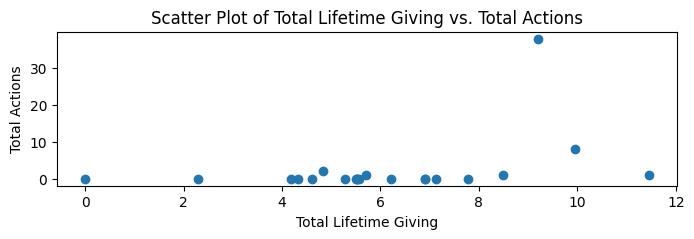

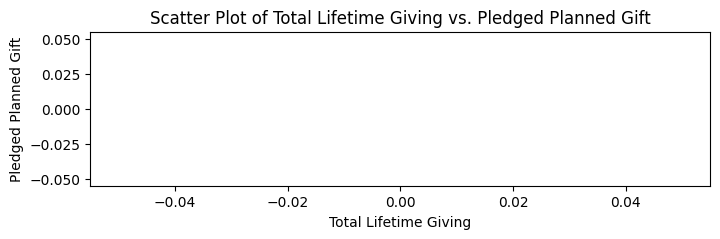

In [114]:
# Drop rows with NaNs in these columns
df_cleaned = df_cdi_multiple.dropna(subset=["Total Lifetime Giving", "Total Actions"])
plt.figure(figsize=(8,2))
plt.scatter(np.log(df_cleaned["Total Lifetime Giving"].astype(float)), \
            df_cleaned["Total Actions"].astype(int))
plt.xlabel("Total Lifetime Giving")
plt.ylabel("Total Actions")
plt.title("Scatter Plot of Total Lifetime Giving vs. Total Actions")
plt.show()

df_cleaned = df_cdi_multiple.dropna(subset=["Total Lifetime Giving", "Pledged Planned Gift"])
plt.figure(figsize=(8,2))
plt.scatter(np.log(df_cleaned["Total Lifetime Giving"].astype(float)), \
            df_cleaned["Pledged Planned Gift"].astype(float))
plt.xlabel("Total Lifetime Giving")
plt.ylabel("Pledged Planned Gift")
plt.title("Scatter Plot of Total Lifetime Giving vs. Pledged Planned Gift")
plt.show()

# **Preprocessing after mapping**

In [92]:
df["class_year"] = df["class_year"].str.split("'",expand=True)[1]
df["class_year"] = df["class_year"].fillna(np.nan).astype('Int64')

In [93]:
mask = ~df["class_year"].isna()
df.loc[mask, "class_year"] = np.where((df.loc[mask, "class_year"] > 25),
                                      "19" + df.loc[mask, "class_year"].astype(str),
                                      "20" + df.loc[mask, "class_year"].astype(str))

In [94]:
cols_datetime = list(df.select_dtypes(include=['datetime']).columns)
for col in cols_datetime:
    df[col] = pd.to_datetime(df[col]).dt.date